In [1]:
#importing libraries
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
import regex as re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# importing to_categorical from keras
from tensorflow.keras.utils import to_categorical

In [3]:
#importing NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [4]:
# importing visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#importing Model Building libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [6]:
df=pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [8]:
X = df['Review']
y = df['Rating'] -1

In [9]:
df['num_words'] = X.apply(lambda x: len(x.split()))

In [10]:
df.head()

,Review,Rating,num_words
0,nice hotel expensive parking got good deal sta...,4,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4* experience hotel monaco seat...,3,217
3,"unique, great stay, wonderful time hotel monac...",5,89
4,"great stay great stay, went seahawk game aweso...",5,191


Text(0.5, 1.0, 'Distribution of the Words count')

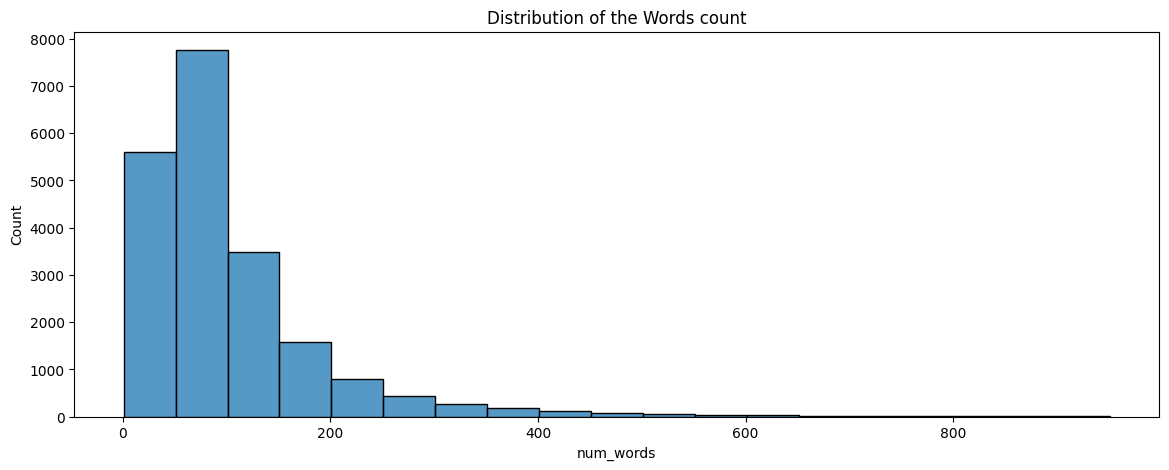

In [11]:
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 1000, 50))
plt.title('Distribution of the Words count')

In [12]:
print(X.isnull().values.any())
print(X.shape)

False
(20491,)


## PRE PROCESSING

In [13]:
# Converting text to lowercase
reviews=X.str.lower()   

In [14]:
X.shape

(20491,)

In [15]:
tag_rem = re.compile(r'<[^>]+>')

def remove_tags(text):
    return tag_rem.sub('', text)

In [16]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"[\s\n\t].[\s\n\t]", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    sentence = sentence.strip().split()

    return sentence

In [17]:
reviews_list = []
sentences = list(X)
for sen in sentences:
    reviews_list.append(preprocess_text(sen))

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
stopwords = stopwords.words('english')

In [20]:
def customtokenize(stri):
    
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords, stri))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(str(word)) for word in nostop ]
    
    return lemmatized

In [21]:
lemmatized_reviews=customtokenize(reviews_list)

In [22]:
##define the parameters for tokenizing and padding
vocab_size = 100000
embedding_dim = 32
max_length = 200
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

In [23]:
tokenizer.fit_on_texts(reviews_list)

In [24]:
import pickle

In [25]:
with open('tokenizer_data.pkl', 'wb') as handle:
    pickle.dump(
        {'tokenizer': tokenizer}, handle)

In [25]:
mappings=tokenizer.word_index

In [26]:
len(mappings)

49130

In [27]:
from nltk.inference.resolution import test_clausify
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [28]:
train_seqs = tokenizer.texts_to_sequences(X)
padded_sequences = keras.preprocessing.sequence.pad_sequences(train_seqs ,padding="post",maxlen=max_length,truncating="post")

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, y, random_state = 1)


In [29]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [30]:
train_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [31]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='selu', input_shape=(200,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_mlp.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [32]:
num_epochs = 15
history_mlp = model_mlp.fit(train_data, 
    train_labels, 
    epochs=num_epochs,
    batch_size=64,
    shuffle=True,
    validation_data=(test_data, test_labels),callbacks = [EarlyStopping(monitor='val_acc', patience=2)]
    )

Epoch 1/15
241/241 [==============================] - 8s 13ms/step - loss: 999.3583 - accuracy: 0.2782 - val_loss: 7.2275 - val_accuracy: 0.2001
Epoch 2/15
241/241 [==============================] - 2s 10ms/step - loss: 81.5259 - accuracy: 0.2005 - val_loss: 3.8455 - val_accuracy: 0.0716
Epoch 3/15
241/241 [==============================] - 2s 10ms/step - loss: 20.0011 - accuracy: 0.1459 - val_loss: 3.0890 - val_accuracy: 0.0722
Epoch 4/15
241/241 [==============================] - 2s 10ms/step - loss: 9.0621 - accuracy: 0.1463 - val_loss: 2.4229 - val_accuracy: 0.0724
Epoch 5/15
241/241 [==============================] - 2s 10ms/step - loss: 5.9348 - accuracy: 0.1709 - val_loss: 1.9159 - val_accuracy: 0.3041
Epoch 6/15
241/241 [==============================] - 2s 9ms/step - loss: 4.5754 - accuracy: 0.1999 - val_loss: 1.5823 - val_accuracy: 0.3041
Epoch 7/15
241/241 [==============================] - 2s 10ms/step - loss: 4.2811 - accuracy: 0.2392 - val_loss: 1.4202 - val_accuracy: 0.3

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=200),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [34]:
num_epochs = 15
history_rnn = model.fit(train_data, 
    train_labels, 
    epochs=num_epochs,
    batch_size=64,
    shuffle=True,
    validation_data=(test_data, test_labels),callbacks = [EarlyStopping(monitor='val_acc', patience=2)]
    )

Epoch 1/15
241/241 [==============================] - 84s 232ms/step - loss: 1.0557 - accuracy: 0.5474 - val_loss: 0.8916 - val_accuracy: 0.6112
Epoch 2/15
241/241 [==============================] - 42s 175ms/step - loss: 0.7707 - accuracy: 0.6626 - val_loss: 0.8691 - val_accuracy: 0.6174
Epoch 3/15
241/241 [==============================] - 46s 191ms/step - loss: 0.6144 - accuracy: 0.7450 - val_loss: 0.9461 - val_accuracy: 0.6096
Epoch 4/15
241/241 [==============================] - 42s 172ms/step - loss: 0.4610 - accuracy: 0.8196 - val_loss: 1.1141 - val_accuracy: 0.5877
Epoch 5/15
241/241 [==============================] - 42s 173ms/step - loss: 0.3454 - accuracy: 0.8699 - val_loss: 1.3841 - val_accuracy: 0.5897
Epoch 6/15
241/241 [==============================] - 41s 172ms/step - loss: 0.2576 - accuracy: 0.9052 - val_loss: 1.6544 - val_accuracy: 0.5737
Epoch 7/15
241/241 [==============================] - 42s 173ms/step - loss: 0.1837 - accuracy: 0.9371 - val_loss: 1.8931 - val_ac

In [35]:
# model_relu = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])
# model_relu.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model_relu.summary()

# CNN model using word2vec

In [36]:
# Import word2vec from gensim
from gensim.models import Word2Vec

In [37]:
df.head()

,Review,Rating,num_words
0,nice hotel expensive parking got good deal sta...,4,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4* experience hotel monaco seat...,3,217
3,"unique, great stay, wonderful time hotel monac...",5,89
4,"great stay great stay, went seahawk game aweso...",5,191


In [38]:
reviews = df['Review'].tolist()

In [39]:
new = []
for review in reviews:
    review = review.lower()
    review = re.sub(r'[^\w\s]','',review)
    review = re.sub(r'\d+','',review)
    review = re.sub(r'\s+',' ',review)
    new.append(review.strip().split())

In [40]:
# Train word2vec over ratings
word_emb = Word2Vec(new, window=5, min_count=1, workers=4, vector_size=10)

In [41]:
emb_df = (
    pd.DataFrame(
        [word_emb.wv.get_vector(str(n)) for n in word_emb.wv.key_to_index],
        index = word_emb.wv.key_to_index
    )
)
emb_df

,0,1,2,3,4,5,6,7,8,9
hotel,3.414304,-0.142787,2.745925,-1.268533,-0.778129,3.056199,1.126630,0.494636,0.592362,-2.707417
room,-1.026669,-1.351674,1.545699,2.502101,2.437633,1.675981,-0.868864,3.563679,0.944368,-6.124699
not,2.251282,0.630992,-0.225997,0.036614,-0.441223,0.945654,-1.078788,4.692199,-1.777126,-1.334647
great,0.928715,-0.456779,3.469937,-2.956624,0.101951,1.611636,2.281356,2.062550,0.167222,0.407502
nt,2.363626,-0.309844,-1.469855,-0.012102,-1.261779,2.031087,-1.897785,6.499581,-2.712606,-0.477392
...,...,...,...,...,...,...,...,...,...,...
agreei,0.032170,-0.077247,-0.024995,0.022506,-0.021994,0.039293,-0.033009,0.056763,-0.021624,-0.031475
startsthe,0.076005,-0.110473,0.077985,0.072883,0.032206,0.038547,-0.045636,0.000786,-0.090381,0.044398
awaya,-0.025064,-0.078771,0.041227,0.106624,-0.003750,-0.016223,0.081161,-0.005431,-0.116800,-0.012459
everydayjust,0.033136,0.094465,-0.084772,-0.054694,0.040712,-0.028157,0.094210,0.108297,0.041439,0.002681


In [42]:
# Convert reviews to vectors of length 100 with 0 padding
review_vecs = []
for review in new:
    review_vec = []
    for word in review[:100]:
        try:
            review_vec.append(word_emb.wv.get_vector(word))
        except:
            review_vec.append(np.zeros(10))
    
    if len(review_vec) < 100:
        review_vec.extend([np.zeros(10)] * (100 - len(review_vec)))

    review_vecs.append(np.array(review_vec))



In [43]:
review_vecs[0]

array([[-1.35008705e+00,  2.60996819e-01,  1.60910654e+00,
        -2.58495808e+00,  1.32407701e+00,  4.20542240e-01,
         2.35227156e+00,  3.42490196e+00,  3.57805520e-01,
        -1.92797267e+00],
       [ 3.41430426e+00, -1.42786831e-01,  2.74592495e+00,
        -1.26853299e+00, -7.78128982e-01,  3.05619931e+00,
         1.12663031e+00,  4.94635582e-01,  5.92361629e-01,
        -2.70741677e+00],
       [ 3.47743797e+00,  2.14095545e+00,  1.99443245e+00,
         3.24529982e+00,  2.69306600e-01,  7.48276889e-01,
         3.42574573e+00,  3.22293782e+00, -3.30036092e+00,
         1.69470775e+00],
       [ 3.55841756e+00, -1.32335746e+00, -3.16012192e+00,
         4.78327560e+00, -1.39748442e+00, -5.25508702e-01,
         2.15483904e+00,  1.39875901e+00, -4.33062124e+00,
        -1.04998493e+00],
       [ 1.58549058e+00, -3.70561266e+00,  1.34345508e+00,
         2.11402369e+00,  1.16894329e+00,  1.11962259e-01,
        -3.34846973e+00,  2.88314080e+00, -1.35289288e+00,
        -6.

In [44]:
# Print dimensions of review vectors
print(len(review_vecs))
print(review_vecs[0].shape)

20491
(100, 10)


In [45]:
review_vecs = np.array(review_vecs)
review_vecs.shape

(20491, 100, 10)

In [46]:
# # Use review_to_vec to convert reviews to vectors
# review_vecs = np.array([review_to_vec(review) for review in new[:100]])


In [47]:
print(len(review_vecs))
print(len(review_vecs[0])*50)

20491
5000


In [48]:
y = to_categorical(((df['Rating']-1).to_list()))

In [49]:
# x = []
# for review in review_vecs:
#     x.append(review.flatten())
# x = np.array(x)
# x = np.asarray(x).astype('float32')

In [50]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(review_vecs, y, random_state = 1)

In [51]:
# Create an CNN model_new for training
model_new = tf.keras.Sequential([
    # model input is input shape of review vectors
    tf.keras.layers.Input(shape=(100, 10, 1)),
    # Batch normalization layer
    tf.keras.layers.Conv2D(64, 5, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    # tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [52]:
model_new.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_new.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 6, 64)         1664      
                                                                 
 batch_normalization (BatchN  (None, 96, 6, 64)        256       
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  (None, 96, 6, 64)        256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 2, 32)         51232     
                                                                 
 batch_normalization_2 (Batc  (None, 92, 2, 32)        128       
 hNormalization)                                                 
                                                      

In [53]:
for i in range(75):
    # train_data[i] = train_data[i].reshape(100, 10, 1)
    print(train_data[i].shape)
# train_data[0].reshape(100, 10, 1).shape

(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)


In [54]:
# Train model
num_epochs = 15
history_cnn = model_new.fit(train_data,
    train_labels,
    epochs=num_epochs,
    batch_size=64,
    shuffle=True,
    validation_data=(test_data, test_labels)
    )


Epoch 1/15
241/241 [==============================] - 31s 30ms/step - loss: 1.3810 - accuracy: 0.4628 - val_loss: 1.2878 - val_accuracy: 0.4290
Epoch 2/15
241/241 [==============================] - 8s 33ms/step - loss: 1.1026 - accuracy: 0.5451 - val_loss: 1.1624 - val_accuracy: 0.4817
Epoch 3/15
241/241 [==============================] - 8s 35ms/step - loss: 0.9395 - accuracy: 0.6012 - val_loss: 1.1875 - val_accuracy: 0.5110
Epoch 4/15
241/241 [==============================] - 9s 36ms/step - loss: 0.8189 - accuracy: 0.6601 - val_loss: 1.2853 - val_accuracy: 0.5186
Epoch 5/15
241/241 [==============================] - 8s 35ms/step - loss: 0.6898 - accuracy: 0.7205 - val_loss: 1.2897 - val_accuracy: 0.5290
Epoch 6/15
241/241 [==============================] - 8s 35ms/step - loss: 0.5699 - accuracy: 0.7745 - val_loss: 1.3993 - val_accuracy: 0.5247
Epoch 7/15
241/241 [==============================] - 8s 35ms/step - loss: 0.4758 - accuracy: 0.8129 - val_loss: 1.5741 - val_accuracy: 0.506

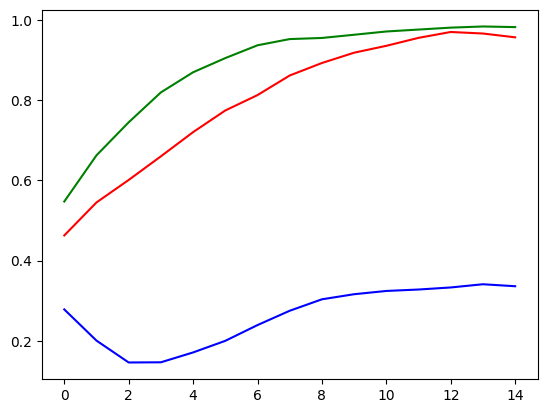

In [55]:
# Plot history of both models
label=["CNN","RNN","MLP"]
colors=["r","g","b"]
plt.plot(history_cnn.history['accuracy'],c=colors[0], label=str(label[0]))
plt.plot(history_rnn.history['accuracy'],c=colors[1], label=str(label[1]))
plt.plot(history_mlp.history['accuracy'],c=colors[2], label=str(label[2]))


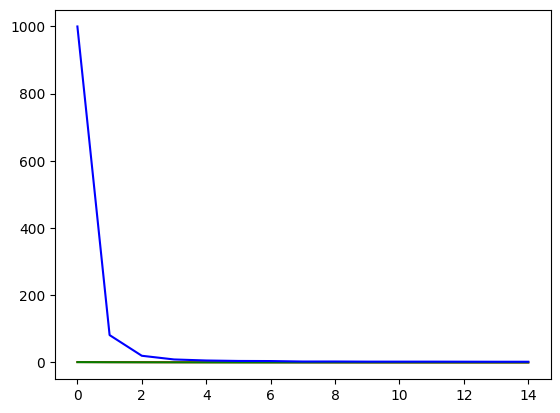

In [56]:
# Plot history of Loss
label=["CNN","RNN","MLP"]
colors=["r","g","b"]
plt.plot(history_cnn.history['loss'],c=colors[0], label=str(label[0]))
plt.plot(history_rnn.history['loss'],c=colors[1], label=str(label[1]))
plt.plot(history_mlp.history['loss'],c=colors[2], label=str(label[2]))

In [57]:
model.save('model_rnn.h5')

In [58]:
model_mlp.save('model_mlp.h5')

In [59]:
model_new.save('model_cnn.h5')

In [34]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

# Load the dataset
df = pd.read_csv(r'C:\Users\saket\Desktop\xwebsite\ML\NLP\tripadvisor_hotel_reviews.csv')

# Tokenization
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    return tokens

# Create a dictionary from the data
def create_dict(data):
    dictionary = corpora.Dictionary(data)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary

# Create a corpus from the data
def create_corpus(data, dictionary):
    corpus = [dictionary.doc2bow(text) for text in data]
    return corpus

# Train the LDA model
def train_lda_model(corpus, dictionary, num_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=20)
    return lda_model

# Run the code
data = df['Review'].apply(tokenize)
dictionary = create_dict(data)
corpus = create_corpus(data, dictionary)
lda_model = train_lda_model(corpus, dictionary, 5)

In [48]:
import pyLDAvis.gensim_models
import pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

C:\Users\saket\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
#save the above lda_model,corpus, dictionary to a file

import pickle
pickle.dump(lda_model, open('lda_model.pkl', 'wb'))
corpus = pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary = pickle.dump(dictionary, open('dictionary.pkl', 'wb'))

In [2]:
#load the model,corpus,dictionary from the file
lda_model = pickle.load(open('lda_model.pkl', 'rb'))
corpus = pickle.load(open('corpus.pkl', 'rb'))
dictionary = pickle.load(open('dictionary.pkl', 'rb'))

In [45]:

# doc = "There was water all over the floor of the bathroom. The towels were dirty and the toilet was not clean"
# doc="The tour was amazing! The guide was very knowledgeable and the scenery was beautiful."
bow = dictionary.doc2bow(doc.lower().split())
topics = lda_model.get_document_topics(bow)


#inference of above corpus or topic using loaded lda_model
lda_model.get_document_topics(corpus)

# Get the topic with the highest probability
topic = max(topics, key=lambda item: item[1])[0]
print("Topic: {}".format(topic))

print(topics)


Topic: 1
[(0, 0.1811513), (1, 0.34806645), (2, 0.17553729), (3, 0.07892642), (4, 0.21631856)]


In [36]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')

Topic: 0 
Words: 0.025*"water" + 0.020*"shower" + 0.020*"towel" + 0.015*"floor" + 0.012*"change" + 0.010*"bathroom" + 0.010*"smell" + 0.009*"toilet" + 0.009*"cleaned" + 0.009*"table"


Topic: 1 
Words: 0.025*"location" + 0.024*"room" + 0.020*"breakfast" + 0.019*"clean" + 0.018*"stayed" + 0.016*"night" + 0.015*"excellent" + 0.013*"small" + 0.013*"helpful" + 0.013*"bathroom"


Topic: 2 
Words: 0.033*"service" + 0.015*"night" + 0.015*"problem" + 0.011*"guest" + 0.010*"check" + 0.010*"booked" + 0.010*"arrived" + 0.010*"people" + 0.009*"room" + 0.009*"experience"


Topic: 3 
Words: 0.062*"beach" + 0.054*"resort" + 0.025*"restaurant" + 0.023*"people" + 0.021*"drink" + 0.020*"water" + 0.016*"vacation" + 0.015*"punta" + 0.014*"beautiful" + 0.014*"ocean"


Topic: 4 
Words: 0.029*"really" + 0.028*"place" + 0.021*"little" + 0.015*"buffet" + 0.012*"wonderful" + 0.011*"lovely" + 0.011*"loved" + 0.010*"night" + 0.009*"review" + 0.009*"beautiful"


